## **IMPORTS**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# **LOAD DATASETS**

In [2]:
# Load the datasets

dga_df = pd.read_csv('/content/combined_dga.csv')
tunnel_df = pd.read_csv('/content/combined_dnsexfil.csv')

### REMOVE NON NUMBERIC COLUMNS

In [3]:
# Drop the first 4 columns and the last column (src ip, dest ip, src port, dest port, DoH)
dga_df = dga_df.iloc[:, 5:-1]
tunnel_df = tunnel_df.iloc[:, 5:-1]

### COMBINE DATASETS

In [4]:
# Attach labels before plotting
dga_df['label'] = 0
tunnel_df['label'] = 1
df = pd.concat([dga_df, tunnel_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df.fillna(df.median(numeric_only=True))

### SELECT RELEVANT FEATURES

In [5]:
correlation = df.corr()
print(correlation['label'].sort_values(ascending=False))

label                                     1.000000
PacketLengthCoefficientofVariation        0.519080
PacketLengthStandardDeviation             0.481030
PacketLengthMean                          0.480741
PacketLengthVariance                      0.267484
PacketTimeVariance                        0.253779
Duration                                  0.243593
PacketTimeStandardDeviation               0.241102
PacketTimeMean                            0.221794
PacketTimeMedian                          0.208300
PacketTimeMode                            0.188142
ResponseTimeTimeMode                      0.151193
ResponseTimeTimeMean                      0.149936
ResponseTimeTimeMedian                    0.139391
PacketLengthSkewFromMedian                0.135553
ResponseTimeTimeStandardDeviation         0.081318
ResponseTimeTimeCoefficientofVariation    0.070977
ResponseTimeTimeSkewFromMedian            0.017375
PacketLengthMedian                       -0.006245
PacketLengthMode               

In [6]:
print(df.head())

     Duration  FlowBytesSent  FlowSentRate  FlowBytesReceived  \
0  120.032639         622040   5182.257136             482977   
1    2.272440            330    145.218356                270   
2  129.963902           8275     63.671526               5847   
3  120.053733         130293   1085.289035              91404   
4    2.265471            330    145.665074                270   

   FlowReceivedRate  PacketLengthVariance  PacketLengthStandardDeviation  \
0       4023.713917           1978.807010                      44.483784   
1        118.815018             36.000000                       6.000000   
2         44.989416          26587.061944                     163.055395   
3        761.359082          14575.308449                     120.728242   
4        119.180515             36.000000                       6.000000   

   PacketLengthMean  PacketLengthMedian  PacketLengthMode  ...  \
0        113.533032                99.0                54  ...   
1         60.000000 

### DROP FEATURES WITH ABS CORRELATION COEFFECIENT LESS THAN 0.2

In [7]:
columns_to_drop = [
    'PacketTimeMode',
    'ResponseTimeTimeMode',
    'ResponseTimeTimeMean',
    'ResponseTimeTimeMedian',
    'PacketLengthSkewFromMedian',
    'ResponseTimeTimeStandardDeviation',
    'ResponseTimeTimeCoefficientofVariation',
    'ResponseTimeTimeSkewFromMedian',
    'PacketLengthMedian',
    'PacketLengthMode'
]

df = df.drop(columns=columns_to_drop)


In [8]:
print(df)


        Duration  FlowBytesSent  FlowSentRate  FlowBytesReceived  \
0     120.032639         622040   5182.257136             482977   
1       2.272440            330    145.218356                270   
2     129.963902           8275     63.671526               5847   
3     120.053733         130293   1085.289035              91404   
4       2.265471            330    145.665074                270   
...          ...            ...           ...                ...   
5068  120.053826          62095    517.226331              49788   
5069   99.089249         634533   6403.651318             506278   
5070    1.062050            333    313.544560                186   
5071  120.942036          57044    471.663963              44263   
5072  120.021590         520027   4332.778794             388649   

      FlowReceivedRate  PacketLengthVariance  PacketLengthStandardDeviation  \
0          4023.713917           1978.807010                      44.483784   
1           118.815018   

### Check for NaN values

In [9]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [10]:
print(X)

        Duration  FlowBytesSent  FlowSentRate  FlowBytesReceived  \
0     120.032639         622040   5182.257136             482977   
1       2.272440            330    145.218356                270   
2     129.963902           8275     63.671526               5847   
3     120.053733         130293   1085.289035              91404   
4       2.265471            330    145.665074                270   
...          ...            ...           ...                ...   
5068  120.053826          62095    517.226331              49788   
5069   99.089249         634533   6403.651318             506278   
5070    1.062050            333    313.544560                186   
5071  120.942036          57044    471.663963              44263   
5072  120.021590         520027   4332.778794             388649   

      FlowReceivedRate  PacketLengthVariance  PacketLengthStandardDeviation  \
0          4023.713917           1978.807010                      44.483784   
1           118.815018   

In [11]:
nan_counts = df.isnull().sum()
print("NaN counts per column:")
print(nan_counts)

NaN counts per column:
Duration                              0
FlowBytesSent                         0
FlowSentRate                          0
FlowBytesReceived                     0
FlowReceivedRate                      0
PacketLengthVariance                  0
PacketLengthStandardDeviation         0
PacketLengthMean                      0
PacketLengthSkewFromMode              0
PacketLengthCoefficientofVariation    0
PacketTimeVariance                    0
PacketTimeStandardDeviation           0
PacketTimeMean                        0
PacketTimeMedian                      0
PacketTimeSkewFromMedian              0
PacketTimeSkewFromMode                0
PacketTimeCoefficientofVariation      0
ResponseTimeTimeVariance              0
ResponseTimeTimeSkewFromMode          0
label                                 0
dtype: int64


### CREATE TRAINING AND TESTING DATASETS

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **K-Nearest Neighbours**

In [13]:
# Scale the features (KNN is sensitive to scale)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune n_neighbors
knn.fit(X_train_scaled, y_train)

# Make predictions and evaluate
y_pred = knn.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9586206896551724
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       601
           1       0.93      0.97      0.95       414

    accuracy                           0.96      1015
   macro avg       0.96      0.96      0.96      1015
weighted avg       0.96      0.96      0.96      1015



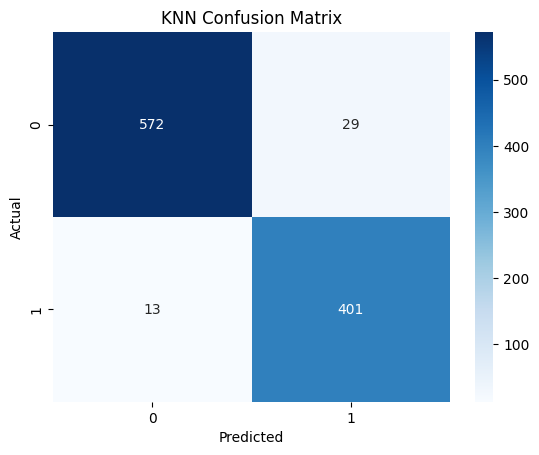

In [14]:
# Confusion matrix for KNN
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')
plt.show()

# **Naive Bayes Model**

Accuracy: 0.865024630541872

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       601
           1       0.78      0.93      0.85       414

    accuracy                           0.87      1015
   macro avg       0.86      0.88      0.86      1015
weighted avg       0.88      0.87      0.87      1015



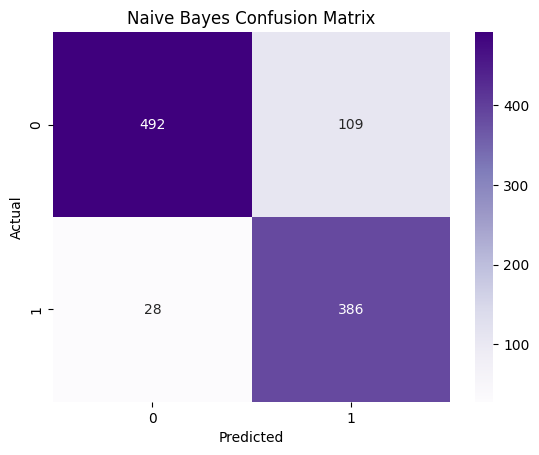

In [15]:
# Use GaussianNB (suitable for continuous features like index)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred = nb_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes Confusion Matrix')
plt.show()


In [16]:
print("Shape of df:", df.shape)
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])


Shape of df: (5073, 20)
Number of rows: 5073
Number of columns: 20


# **Random Forest Classifier**

In [17]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9714285714285714
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       601
           1       0.96      0.97      0.97       414

    accuracy                           0.97      1015
   macro avg       0.97      0.97      0.97      1015
weighted avg       0.97      0.97      0.97      1015



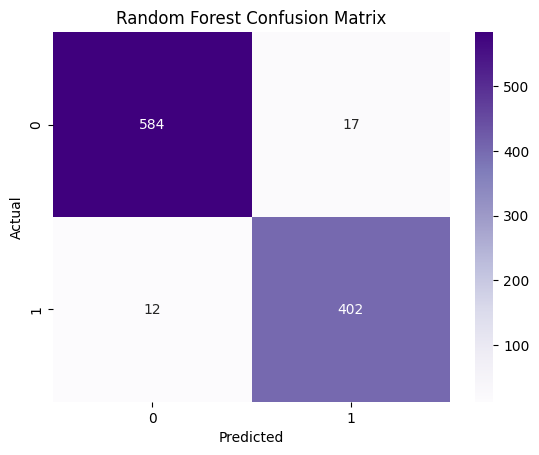

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()
